# Car NLP project

# 1. 处理数据集

In [46]:
import os
import pandas as pd

In [47]:
# 文件路径（确认你的路径和文件名）
data_dir = 'data'
train_path = os.path.join(data_dir, 'train.txt')
test_path = os.path.join(data_dir, 'test.txt')

In [48]:
def load_data(file_path):
    texts = []
    themes = []
    sentiments = []
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # 分成两部分：文本\t主题#情感
            parts = line.split('\t')
            if len(parts) < 2:
                continue
            text = parts[0]
            tags = parts[1:]
            theme_labels = []
            sentiment_labels = []
            for tag in tags:
                # 主题#情感
                if '#' in tag:
                    theme, sentiment = tag.split('#')
                    theme_labels.append(theme)
                    sentiment_labels.append(int(sentiment))
            texts.append(text)
            themes.append(theme_labels)
            sentiments.append(sentiment_labels)
    return pd.DataFrame({'text': texts, 'themes': themes, 'sentiments': sentiments})

df_train = load_data(train_path)
df_test = load_data(test_path)

df_train.head()


,text,themes,sentiments
0,因为 森林 人 即将 换代 ， 这套 系统 没 必要 装 在 一 款 即将 换代 的 车型 ...,[价格],[0]
1,四驱 价格 貌似 挺 高 的 ， 高 的 可以 看齐 XC 60 了 ， 看 实 车前 脸 ...,[价格],[-1]
2,斯柯达 要说 质量 ， 似乎 比 大众 要 好 一点 ， 价格 也 低 一些 ， 用料 完全...,[价格],[1]
3,这 玩意 都 是 给 有钱 任性 又 不 懂 车 的 土豪 用 的 ， 这 价格 换 一 次...,[价格],[-1]
4,17 价格 忒 高 ， 估计 也 就是 14 - 15 左右 。,[价格],[-1]


# 2. 标签编码


In [49]:
# 10个主题（一定要顺序稳定）
THEMES = ['动力', '价格', '内饰', '配置', '安全性', '外观', '操控', '油耗', '空间', '舒适性']
THEME2IDX = {theme: idx for idx, theme in enumerate(THEMES)}
N_THEMES = len(THEMES)

# 情感标签：正向1, 中立0, 负向-1
SENTIMENTS = [-1, 0, 1]
SENTIMENT2IDX = {v: i for i, v in enumerate(SENTIMENTS)}


## 2.1 主题 Multi-hot 编码（多标签）

In [50]:
import numpy as np

def encode_themes(theme_list):
    multi_hot = np.zeros(N_THEMES, dtype=int)
    for theme in theme_list:
        if theme in THEME2IDX:
            multi_hot[THEME2IDX[theme]] = 1
    return multi_hot

df_train['theme_multi_hot'] = df_train['themes'].apply(encode_themes)
df_test['theme_multi_hot'] = df_test['themes'].apply(encode_themes)


## 2.2 情感标签编码

### A. 情感三分类（整体标签）

In [51]:
def sum_sentiment_label(senti_list):
    s = sum(senti_list)
    if s > 0:
        return 1  # 正向
    elif s < 0:
        return -1 # 负向
    else:
        return 0  # 中立

df_train['sentiment_sum'] = df_train['sentiments'].apply(sum_sentiment_label)
df_test['sentiment_sum'] = df_test['sentiments'].apply(sum_sentiment_label)


### B. 每个主题的情感（多标签）

In [52]:
def encode_theme_sentiments(theme_list, senti_list):
    labels = np.zeros(N_THEMES, dtype=int)
    for theme, senti in zip(theme_list, senti_list):
        if theme in THEME2IDX:
            labels[THEME2IDX[theme]] = senti  # -1, 0, 1
    return labels

df_train['theme_sentiments'] = df_train.apply(lambda row: encode_theme_sentiments(row['themes'], row['sentiments']), axis=1)
df_test['theme_sentiments'] = df_test.apply(lambda row: encode_theme_sentiments(row['themes'], row['sentiments']), axis=1)


In [53]:
# 检查一下数据结构
print(df_train[['text', 'theme_multi_hot', 'sentiment_sum', 'theme_sentiments']].head())


                                                text  \
0  因为 森林 人 即将 换代 ， 这套 系统 没 必要 装 在 一 款 即将 换代 的 车型 ...   
1  四驱 价格 貌似 挺 高 的 ， 高 的 可以 看齐 XC 60 了 ， 看 实 车前 脸 ...   
2  斯柯达 要说 质量 ， 似乎 比 大众 要 好 一点 ， 价格 也 低 一些 ， 用料 完全...   
3  这 玩意 都 是 给 有钱 任性 又 不 懂 车 的 土豪 用 的 ， 这 价格 换 一 次...   
4                   17 价格 忒 高 ， 估计 也 就是 14 - 15 左右 。   

                  theme_multi_hot  sentiment_sum  \
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]              0   
1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]             -1   
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]              1   
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]             -1   
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]             -1   

                  theme_sentiments  
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1  [0, -1, 0, 0, 0, 0, 0, 0, 0, 0]  
2   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
3  [0, -1, 0, 0, 0, 0, 0, 0, 0, 0]  
4  [0, -1, 0, 0, 0, 0, 0, 0, 0, 0]  


# 3. BERT输入格式+数据集封装

In [68]:
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset, DataLoader

# 指定本地下载路径
cache_path = 'model/'

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', cache_dir=cache_path)
bert_model = BertModel.from_pretrained('bert-base-chinese', cache_dir=cache_path)

MAX_LEN = 64  # 按你文本实际长度微调，一般40-128都行

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

In [70]:
class CarOpinionDataset(Dataset):
    def __init__(self, df, task='sentiment'):
        self.texts = df['text'].tolist()
        self.themes = df['theme_multi_hot'].tolist()
        self.theme_sentiments = df['theme_sentiments'].tolist()
        self.sentiments = df['sentiment_sum'].tolist()
        self.task = task

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        # squeeze: [1, L] -> [L]
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}

        # 单标签 or 多标签
        if self.task == 'sentiment':  # 三分类
            label = torch.tensor(SENTIMENT2IDX[self.sentiments[idx]], dtype=torch.long)
        elif self.task == 'theme':  # 多标签
            label = torch.tensor(self.themes[idx], dtype=torch.float)
        elif self.task == 'theme_sentiments':  # 主题对应情感（进阶任务）
            label = torch.tensor(self.theme_sentiments[idx], dtype=torch.float)
        else:
            raise ValueError("Unknown task")
        return encoding, label

In [71]:
# 例子：情感分类数据集和多标签主题分类数据集
train_sentiment_ds = CarOpinionDataset(df_train, task='sentiment')
train_theme_ds = CarOpinionDataset(df_train, task='theme')

# DataLoader示例
BATCH_SIZE = 32

train_sentiment_loader = DataLoader(train_sentiment_ds, batch_size=BATCH_SIZE, shuffle=True)
train_theme_loader = DataLoader(train_theme_ds, batch_size=BATCH_SIZE, shuffle=True)

# 看看一批数据的结构
batch = next(iter(train_sentiment_loader))
print(batch[0].keys())  # input_ids, token_type_ids, attention_mask
print(batch[1].shape)   # (batch_size,)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([32])


# 4 Bert情感分类
## 4.1 BERT情感三分类模型

In [64]:
from transformers import BertModel
import torch.nn as nn

In [72]:
class BertForSentiment(nn.Module):
    def __init__(self, pretrained_model='bert-base-chinese', num_labels=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output  # [batch, hidden_size]
        out = self.dropout(pooled_output)
        out = self.fc(out)  # [batch, num_labels]
        return out


## 4.2 训练和验证流程

In [75]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSentiment().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    losses = []
    all_labels = []
    all_preds = []
    for batch in tqdm(dataloader, desc="Training", leave=False):  # 加这个！
        inputs, labels = batch
        for k in inputs:
            inputs[k] = inputs[k].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds = outputs.argmax(1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    return np.mean(losses), acc


def eval_model(model, dataloader, criterion):
    model.eval()
    losses = []
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            for k in inputs:
                inputs[k] = inputs[k].to(device)
            labels = labels.to(device)
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            preds = outputs.argmax(1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return np.mean(losses), acc, precision, recall, f1


In [77]:
EPOCHS = 5
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_sentiment_loader, optimizer, criterion)
    val_loss, val_acc, val_prec, val_recall, val_f1 = eval_model(model, train_sentiment_loader, criterion) # 这里建议有验证集，先用训练集当demo
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

Epoch 1: Train Loss 0.5469, Train Acc 0.7758 | Val Loss 0.3914, Val Acc 0.8622


Epoch 2: Train Loss 0.4030, Train Acc 0.8427 | Val Loss 0.2196, Val Acc 0.9366


Epoch 3: Train Loss 0.2772, Train Acc 0.8998 | Val Loss 0.1429, Val Acc 0.9573


Epoch 4: Train Loss 0.1817, Train Acc 0.9383 | Val Loss 0.0673, Val Acc 0.9809


Epoch 5: Train Loss 0.1247, Train Acc 0.9583 | Val Loss 0.1422, Val Acc 0.9481


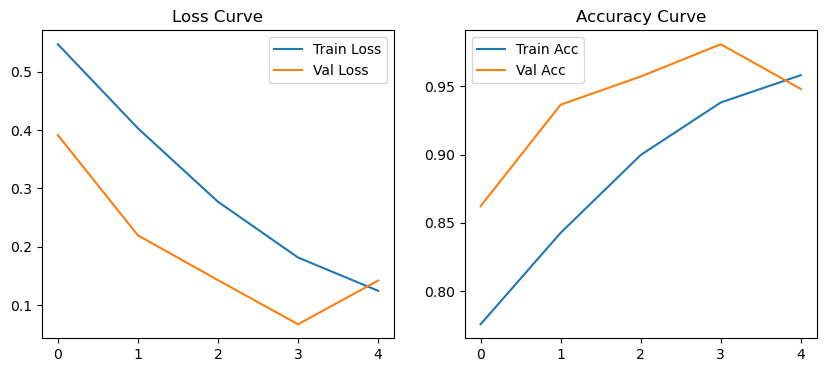

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


Result：
- Loss 趋势：训练/验证都稳定下降，说明模型在学习，没有炸掉。
- Accuracy 趋势：准确率不断升高，而且训练和验证接近，没有明显过拟合或欠拟合。
- 最后一轮：Train/Val Loss 都很低，Accuracy 很高（0.95+），说明表现很好。

# 5.主题识别（multi-label）

## 5.1 Multi-label BERT模型

In [83]:
class BertForMultiLabelTheme(nn.Module):
    def __init__(self, pretrained_model='bert-base-chinese', num_labels=10):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model, cache_dir='model/')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        out = self.dropout(pooled_output)
        out = self.fc(out)  # [batch, num_labels]
        out = torch.sigmoid(out)  # 多标签需要sigmoid
        return out


## 5.2. 换 Loss、标签和指标

In [84]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForMultiLabelTheme().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

def train_multilabel_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    losses = []
    all_labels = []
    all_preds = []
    for batch in tqdm(dataloader, desc="Training multi-label", leave=False):
        inputs, labels = batch
        for k in inputs:
            inputs[k] = inputs[k].to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds = (outputs > 0.5).int().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    return np.mean(losses), acc

def eval_multilabel_model(model, dataloader, criterion):
    model.eval()
    losses = []
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating multi-label", leave=False):
            inputs, labels = batch
            for k in inputs:
                inputs[k] = inputs[k].to(device)
            labels = labels.to(device)
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            preds = (outputs > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return np.mean(losses), acc, precision, recall, f1


Epoch 1: Train Loss 0.2350, Train Acc 0.4856 | Val Loss 0.1261, Val Acc 0.7775, Macro F1 0.8380


Epoch 2: Train Loss 0.1212, Train Acc 0.7665 | Val Loss 0.0922, Val Acc 0.8200, Macro F1 0.8764


Epoch 3: Train Loss 0.0953, Train Acc 0.8116 | Val Loss 0.0761, Val Acc 0.8411, Macro F1 0.8994


Epoch 4: Train Loss 0.0807, Train Acc 0.8331 | Val Loss 0.0651, Val Acc 0.8591, Macro F1 0.9173


Epoch 5: Train Loss 0.0694, Train Acc 0.8524 | Val Loss 0.0500, Val Acc 0.9032, Macro F1 0.9418


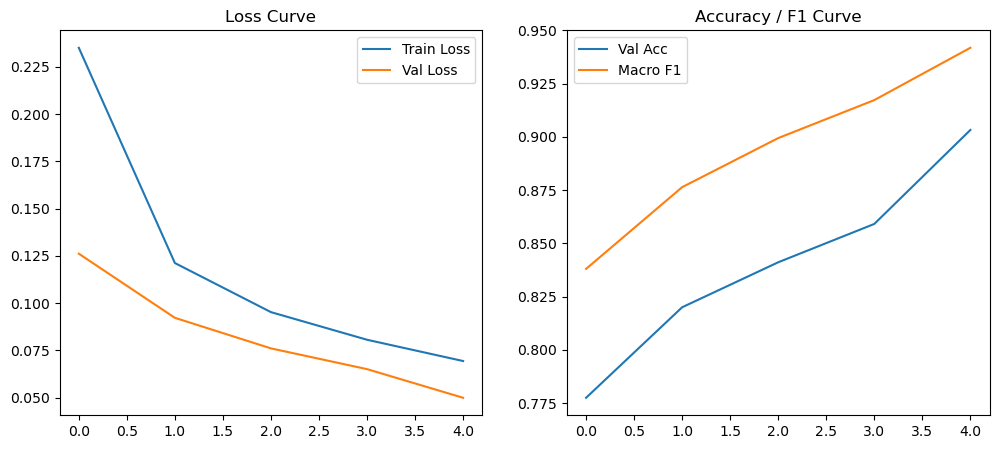

In [85]:
EPOCHS = 5  # 按你的需要来调
train_losses, train_accs, val_losses, val_accs = [], [], [], []
val_precisions, val_recalls, val_f1s = [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_multilabel_one_epoch(model, train_theme_loader, optimizer, criterion)
    val_loss, val_acc, val_prec, val_recall, val_f1 = eval_multilabel_model(model, train_theme_loader, criterion)  # demo用train，实际用val
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}, Macro F1 {val_f1:.4f}")
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

# 画Loss和Accuracy曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.subplot(1,2,2)
plt.plot(val_accs, label='Val Acc')
plt.plot(val_f1s, label='Macro F1')
plt.legend()
plt.title('Accuracy / F1 Curve')
plt.show()


In [86]:
print(df_train.shape)  # (样本数, 列数)
print(df_test.shape)   # (样本数, 列数)


(8000, 6)
(2653, 6)
